In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np

from IPython.display import HTML
from IPython.display import clear_output

class Model(nn.Module):
    def __init__(self, device, n_steps, sigma_min, sigma_max, p=0.5):
        '''
        Score Network.

        n_steps   : perturbation schedule steps (Langevin Dynamic step)
        sigma_min : sigma min of perturbation schedule
        sigma_min : sigma max of perturbation schedule

        '''
        super().__init__()
        self.device = device
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps)).to(device = device)
        
        self.linear_model1 = nn.Sequential(
            nn.Linear(2, 256),
            nn.Dropout(p),
            nn.GELU(),
            

        )
        # Condition sigmas
        self.embedding_layer = nn.Embedding(n_steps, 256)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(p),
            nn.GELU(),
            
            nn.Linear(512, 512),
            nn.Dropout(p),
            nn.GELU(),
            
            nn.Linear(512, 2),
        )
        
        self.to(device = self.device)
        

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)
        
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)

        
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (score prediction)

        '''
        

        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0),)).to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            
        else:
            idx = torch.cat([torch.Tensor([idx for _ in range(x.size(0))])]).long().to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            x_tilde = x

        if get_target:
            target = - 1 / used_sigmas * noise

        output = self.linear_model1(x_tilde)
        embedding = self.embedding_layer(idx)
        output = self.linear_model2(output + embedding)

        return (output, target, used_sigmas) if get_target else output

/tmp/ipykernel_438653/3344449198.py:6: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate


sigmas: $\sigma=\{\sigma_i\}_{i=1}^L$로, $\sigma_{\max}=\sigma_1$부터 $\sigma_{\min}=\sigma_L$까지 n_steps개의 항을 가지며 줄어드는 등비수열

forward(x)
- output: $\mathbf s_{\boldsymbol \theta}(\mathbf x, \sigma)$로, x에 self.sigmas 중 임의의 $\sigma$를 선택해 $\widetilde{\mathbf x} \sim \mathcal N(\mathbf x, \sigma^2 I)$로 x_tilde를 얻은 다음, 2차원 좌표 x_tilde를 self.linear_model에 통과시켜 얻을 수 있다.
- target: $-\frac{\widetilde{\mathbf x}-\mathbf x}{\sigma^2}$으로, target = - 1 / used_sigmas * noise의 식으로 얻을 수 있다.
- used_sigmas: output을 계산할 때 self.sigmas에서 임의로 고른 sigma를 저장한 것이다.

loss_fn(x): forward 함수를 이용하여 scores($\mathbf s_{\boldsymbol \theta}(\mathbf x, \sigma)$), target($-\frac{\widetilde{\mathbf x}-\mathbf x}{\sigma^2}$), sigma($\sigma$)를 받고, 다음과 같이 losses를 계산한다.
$$ \frac{1}{2} \sigma^2 \Big \Vert \mathbf s_{\boldsymbol \theta}(\mathbf x, \sigma) + \frac{\widetilde{\mathbf x}-\mathbf x}{\sigma^2} \Big \Vert_2^2 = \frac{1}{2} \Big \Vert \sigma \mathbf s_{\boldsymbol \theta}(\mathbf x, \sigma) + \frac{\widetilde{\mathbf x}-\mathbf x}{\sigma} \Big \Vert_2^2 $$

그리고 최종적으로 losses.mean(dim=0)을 반환한다.

In [2]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, n_steps, annealed_step, score_fn, device, eps = 1e-1):
        '''
        sigma_min : minimum sigmas of perturbation schedule 
        sigma_max : maximum sigmas of perturbation schedule 
        L         : iteration step of Langevin dynamic
        T         : annelaed step of annealed Langevin dynamic
        score_fn  : trained score network
        eps       : coefficient of step size
        '''

        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.annealed_step = annealed_step
        self.device = device

    def _one_annealed_step_iteration(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''

        self.score_fn.eval()
        z, step_size = torch.randn_like(x).to(device = self.device), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x

    def _one_perturbation_step(self, x):
        '''
        x   : sampling of prior distribution
        '''
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        only_final : If True, return is an only output of final schedule step 
        '''
        sample = (torch.rand([sampling_number,2]).to(device = self.device) - 0.5)*2
        sampling_list = []
        
        final = None
        for sample in self._one_perturbation_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)

process: $\sigma=\{\sigma_i\}_{i=1}^L$로, $\sigma_{\max}=\sigma_1$부터 $\sigma_{\min}=\sigma_L$까지 n_steps개의 항을 가지며 줄어드는 등비수열

step_size: $\alpha_i = \epsilon_i \cdot \sigma_i^2/\sigma_L^2$, score_fn: 위에서 정의한 model로 구해진 score function $\mathbf s_{\boldsymbol \theta}(\mathbf x, \sigma)$

sampling
- sample: -1과 1 사이의 실수 값을 갖는 [sampling_number, 2] size의 tensor로, $\widetilde{\mathbf x}_0$에 해당한다.

- _one_perturbation_step, _one_annealed_step: step size $\alpha_i$를 줄이면서 sampling을 진행한다.

- _one_annealed_step_iteration: z는 $\mathbf z_t \sim \mathcal N(\mathbf 0, \mathbf I)$이고, 이 값에 대해 다음 식을 계산하여 반환한다.

$$\widetilde{\mathbf x}_t = \widetilde{\mathbf x}_{t-1}+\frac{\alpha_i}{2} \mathbf s_{\boldsymbol \theta}(\widetilde{\mathbf x}_{t-1}, \sigma_i)+\sqrt{\alpha_i}\mathbf z_t$$

In [3]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [4]:
def scatter(sample, only_final, scatter_range = [-10, 10]):
    clear_output()
    if only_final:
        scatter = sample.detach().cpu().numpy()
        scatter_x, scatter_y = scatter[:,0], scatter[:,1]
        plt.figure(figsize=(7, 7))

        plt.xlim(scatter_range)
        plt.ylim(scatter_range)
        plt.rc('axes', unicode_minus=False)

        plt.scatter(scatter_x, scatter_y, s=5)
        plt.show()
    
    else:
        step_size = sample.size(0)
        fig, axs = plt.subplots(1, step_size, figsize=(step_size * 4, 4), constrained_layout = True)
        for i in range(step_size):
            scatter = sample[i].detach().cpu().numpy()
            scatter_x, scatter_y = scatter[:,0], scatter[:,1]
            axs[i].scatter(scatter_x, scatter_y, s=5)
            axs[i].set_xlim(scatter_range)
            axs[i].set_ylim(scatter_range)
        plt.show()

In [5]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2, shape = (2), probability=0.2, total_len = 1000000):
        self.dist1_mean, self.dist1_var = dist1[0], dist1[1]
        self.dist2_mean, self.dist2_var = dist2[0], dist2[1]
        self.shape = shape
        self.probability = probability
        self.total_len = total_len
        
    @property
    def get_probability(self):
        return torch.rand(1) < self.probability
        
    @property
    def _sampling_1(self):
        return self.dist1_mean + torch.randn(self.shape) * self.dist1_var

    @property
    def _sampling_2(self):
        return self.dist2_mean + torch.randn(self.shape) * self.dist2_var

    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):
        data = self._sampling_1 if self.get_probability else self._sampling_2

        return data

In [6]:
eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 10
annealed_step = 100
device = torch.device('cuda')

In [7]:
model = Model(device, n_steps, sigma_min, sigma_max, p = 0.3)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)

이제 다음과 같은 분포를 갖는 데이터를 생각해보자.

$$p_{data} = \frac{1}{5} \times \mathcal{N}((3,3), I) + \frac{4}{5} \times \mathcal{N}((-3,-3), I)$$

In [ ]:
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size = 8192 * 2
total_iteration = 1000
dataloader = torch.utils.data.DataLoader(DataSet(dist1, dist2, probability=probability, total_len=batch_size * total_iteration), batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

이 데이터를 좌표평면 위에 plot해보면 다음과 같다.

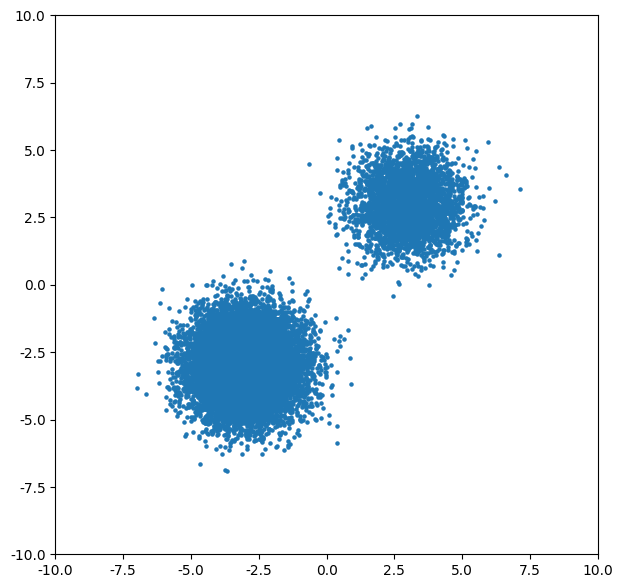

In [13]:
scatter(next(iter(dataloader)), True)

In [14]:
scatter_range = [-10, 10]
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

이제 이 단계에서는 score function을 학습한다. 구체적으로 말하자면, score function에 사용되는 linear model의 parameter를 학습하는 것이다. display_iteration의 간격만큼 plot하여 score function이 잘 학습되고 있는지 확인할 수 있다.

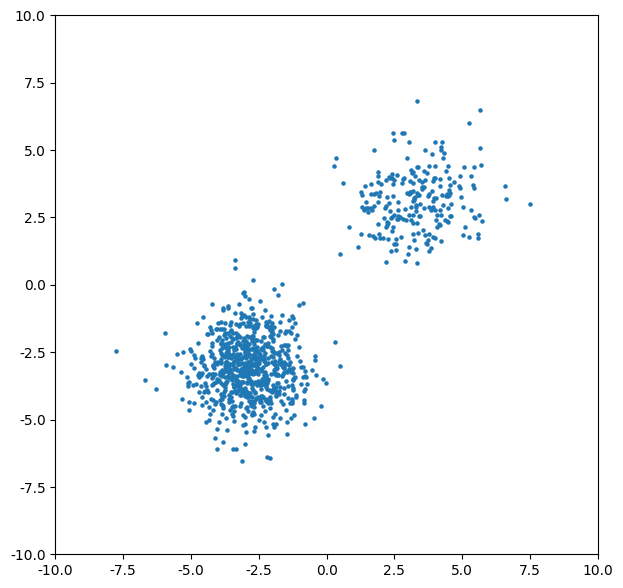

In [16]:
while current_iteration != total_iteration:
    try:
        data = next(dataiterator)
    except:
        dataiterator = iter(dataloader)
        data = next(dataiterator)
    data = data.to(device = device)
    loss = model.loss_fn(data)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.update(loss.item())
    progress.display(current_iteration)
    
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
        sample = dynamic.sampling(sampling_number, only_final)
        scatter(sample, only_final, scatter_range = scatter_range)
        losses.reset()


최종적으로 학습된 score function으로 data distribution을 나타낼 수 있다. 이때 sampling_number를 다르게 하면 샘플의 수를 조절할 수 있다. plot한 결과를 보면 대략적인 4:1의 비율로 잘 나눠지는 것을 확인할 수 있다.

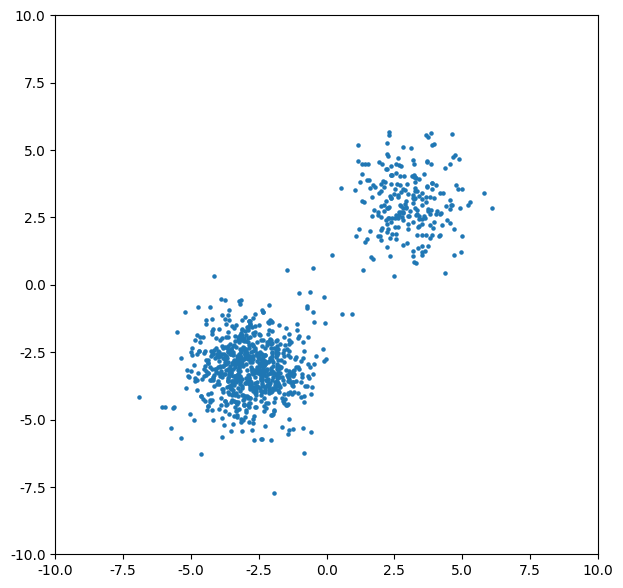

In [17]:
sampling_number = 1000
only_final = True
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range= scatter_range)

중간 과정의 sampling 결과를 그림과 애니메이션으로 나타내면 아래와 같다.

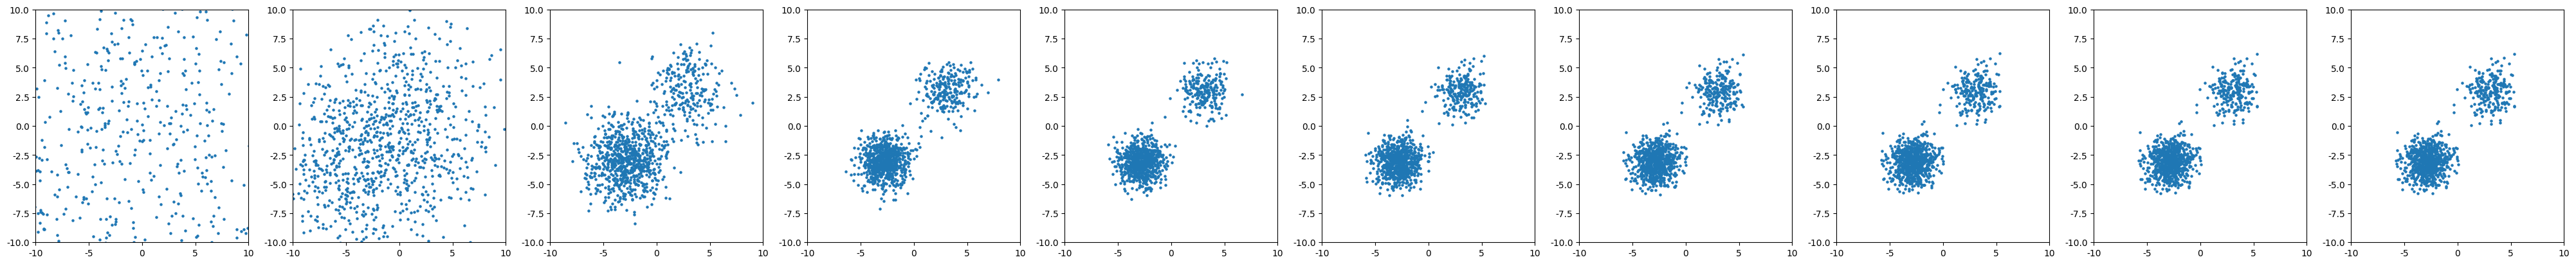

In [18]:
sampling_number = 1000
only_final = False
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range=scatter_range)

In [19]:
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=150)
# ani.save('ncsn_toy.gif')
HTML(ani.to_jshtml())